In [28]:
class  Function(object):
    def forward(self): 
        raise NotImplementedError
    
    def backward(self): 
        raise NotImplementedError
    
    def getParams(self): 
        return []

In [29]:
class Linear(Function):
    def __init__(self,in_nodes,out_nodes):
        self.weights = torch.Tensor((in_nodes,out_nodes))
        self.bias    = torch.Tensor((1,out_nodes))
        self.type = 'linear'

    def forward(self,x):
        output = np.dot(x,self.weights.data)+self.bias.data
        self.input = x 
        return output

    def backward(self,d_y):
        self.weights.grad += np.dot(self.input.T,d_y)
        self.bias.grad    += np.sum(d_y,axis=0,keepdims=True)
        grad_input         = np.dot(d_y,self.weights.data.T)
        return grad_input

    def getParams(self):
        return [self.weights,self.bias]

In [30]:
class Optimizer(object):
    def __init__(self,parameters):
        self.parameters = parameters
    
    def step(self): 
        raise NotImplementedError

    def zeroGrad(self):
        for p in self.parameters:
            p.grad = 0.

In [31]:
class SGD(Optimizer):
    def __init__(self,parameters,lr=.001,weight_decay=0.0,momentum = .9):
        super().__init__(parameters)
        self.lr           = lr
        self.weight_decay = weight_decay
        self.momentum     = momentum
        self.velocity     = []
        for p in parameters:
            self.velocity.append(np.zeros_like(p.grad))

    def step(self):
        for p,v in zip(self.parameters,self.velocity):
            v = self.momentum*v+p.grad+self.weight_decay*p.data
            p.data=p.data-self.lr*v

In [32]:
class  ReLU(Function):
    def __init__(self,inplace=True):
        self.type    = 'activation'
        self.inplace = inplace
    
    def forward(self,x):
        if self.inplace:
            x[x<0] = 0.
            self.activated = x
        else:
            self.activated = x*(x>0)
        
        return self.activated

    def backward(self,d_y):
        return d_y*(self.activated>0)

In [33]:
class Model():
    def __init__(self):
        self.computation_graph = []
        self.parameters        = []

    def add(self,layer):
        self.computation_graph.append(layer)
        self.parameters+=layer.getParams()

    def __innitializeNetwork(self):
        for f in self.computation_graph:
            if f.type=='linear':
                weights,bias = f.getParams()
                weights.data = .01*np.random.randn(weights.data.shape[0],weights.data.shape[1])
                bias.data    = 0.

    def fit(self,data,target,batch_size,num_epochs,optimizer,loss_fn):
        loss_history = []
        self.__innitializeNetwork()
        data_gen = DataGenerator(data,target,batch_size)
        itr = 0
        for epoch in range(num_epochs):
            for X,Y in data_gen:
                optimizer.zeroGrad()
                for f in self.computation_graph: X=f.forward(X)
                loss = loss_fn.forward(X,Y)
                grad = loss_fn.backward()
                for f in self.computation_graph[::-1]: grad = f.backward(grad) 
                loss_history+=[loss]
                print("Loss at epoch = {} and iteration = {}: {}".format(epoch,itr,loss_history[-1]))
                itr+=1
                optimizer.step()
        
        return loss_history
    
    def predict(self,data):
        X = data
        for f in self.computation_graph: X = f.forward(X)
        return X

In [34]:
class SoftmaxWithLoss(Function):
    def __init__(self):
        self.type = 'normalization'

    def forward(self,x,target):
        unnormalized_proba = np.exp(x-np.max(x,axis=1,keepdims=True))
        self.proba         = unnormalized_proba/np.sum(unnormalized_proba,axis=1,keepdims=True)
        self.target        = target
        loss               = -np.log(self.proba[range(len(target)),target]) 
        return loss.mean()

    def backward(self):
        gradient = self.proba
        gradient[range(len(self.target)),self.target]-=1.0
        gradient/=len(self.target)
        return gradient

In [35]:
def genSpiralData(points_per_class,num_classes):
    data   = np.ndarray((points_per_class*num_classes,2),np.float32)
    target = np.ndarray((points_per_class*num_classes,),np.uint8)
    r = np.linspace(0,1,points_per_class)
    radians_per_class = 2*np.pi/num_classes
    for i in range(num_classes):
        t = np.linspace(i*radians_per_class,(i+1.5)*radians_per_class,points_per_class)+0.1*np.random.randn(points_per_class)
        data[i*points_per_class:(i+1)*points_per_class] = np.c_[r*np.sin(t),r*np.cos(t)]
        target[i*points_per_class:(i+1)*points_per_class] = i

    return  data,target

In [36]:
def plot2DDataWithDecisionBoundary(data,target,model):
    x_min,x_max = np.min(data[:,0])-.5,np.max(data[:,0])+.5
    y_min,y_max = np.min(data[:,1])-.5,np.max(data[:,1])+.5
    X,Y = np.arange(x_min,x_max,.02),np.arange(y_min,y_max,.02)
    XX,YY = np.meshgrid(X,Y)
    Z = np.argmax(model.predict(np.c_[XX.ravel(),YY.ravel()]),axis=1).reshape(XX.shape)
    plt.contourf(XX,YY,Z,cmap=plt.cm.seismic)
    plt.scatter(x=data[:,0],y=data[:,1],c=target,cmap=plt.cm.seismic)
    plt.show()

Loss at epoch = 0 and iteration = 0: 1.098639906635686
Loss at epoch = 0 and iteration = 1: 1.103504188574518
Loss at epoch = 0 and iteration = 2: 1.0958367260116768
Loss at epoch = 0 and iteration = 3: 1.0948569001394792
Loss at epoch = 0 and iteration = 4: 1.1004326612024682
Loss at epoch = 0 and iteration = 5: 1.1050915723644645
Loss at epoch = 0 and iteration = 6: 1.1076506631766572
Loss at epoch = 0 and iteration = 7: 1.08695664472221
Loss at epoch = 0 and iteration = 8: 1.1372112507606684
Loss at epoch = 0 and iteration = 9: 1.1345508771521113
Loss at epoch = 0 and iteration = 10: 1.0961152086576276
Loss at epoch = 0 and iteration = 11: 1.1053093278127741
Loss at epoch = 0 and iteration = 12: 1.0867372779513291
Loss at epoch = 0 and iteration = 13: 1.121284657914464
Loss at epoch = 0 and iteration = 14: 1.1233276225514
Loss at epoch = 1 and iteration = 15: 1.0632850541246675
Loss at epoch = 1 and iteration = 16: 1.053397751135115
Loss at epoch = 1 and iteration = 17: 1.0563775975

Loss at epoch = 19 and iteration = 295: 0.34093047124499914
Loss at epoch = 19 and iteration = 296: 0.10838540174206075
Loss at epoch = 19 and iteration = 297: 0.5078801095955692
Loss at epoch = 19 and iteration = 298: 0.949842126368803
Loss at epoch = 19 and iteration = 299: 0.26377321195486136
Loss at epoch = 20 and iteration = 300: 0.3608857607699169
Loss at epoch = 20 and iteration = 301: 0.3498968771615419
Loss at epoch = 20 and iteration = 302: 0.4056092587652455
Loss at epoch = 20 and iteration = 303: 0.2621117959701843
Loss at epoch = 20 and iteration = 304: 0.12907871993235173
Loss at epoch = 20 and iteration = 305: 0.33187722291708543
Loss at epoch = 20 and iteration = 306: 0.5007262015067753
Loss at epoch = 20 and iteration = 307: 0.4814692486170283
Loss at epoch = 20 and iteration = 308: 0.27378761632841464
Loss at epoch = 20 and iteration = 309: 0.324842055379355
Loss at epoch = 20 and iteration = 310: 0.27677062647016454
Loss at epoch = 20 and iteration = 311: 0.407371449

Loss at epoch = 41 and iteration = 624: 0.06970145259790522
Loss at epoch = 41 and iteration = 625: 0.1114514313317873
Loss at epoch = 41 and iteration = 626: 0.15828917173761917
Loss at epoch = 41 and iteration = 627: 0.17055238502124204
Loss at epoch = 41 and iteration = 628: 0.13819305784779742
Loss at epoch = 41 and iteration = 629: 0.129056312076245
Loss at epoch = 42 and iteration = 630: 0.08702768878480521
Loss at epoch = 42 and iteration = 631: 0.06780271405477847
Loss at epoch = 42 and iteration = 632: 0.27704840876045506
Loss at epoch = 42 and iteration = 633: 0.10216471413999306
Loss at epoch = 42 and iteration = 634: 0.12468954332880629
Loss at epoch = 42 and iteration = 635: 0.10456494381647696
Loss at epoch = 42 and iteration = 636: 0.13976117365334034
Loss at epoch = 42 and iteration = 637: 0.08653857890262116
Loss at epoch = 42 and iteration = 638: 0.12875708293292648
Loss at epoch = 42 and iteration = 639: 0.07196419243187306
Loss at epoch = 42 and iteration = 640: 0.1

Loss at epoch = 66 and iteration = 999: 0.10397960696882488
Loss at epoch = 66 and iteration = 1000: 0.1386237688325587
Loss at epoch = 66 and iteration = 1001: 0.06408273061423267
Loss at epoch = 66 and iteration = 1002: 0.2261288942541467
Loss at epoch = 66 and iteration = 1003: 0.18537302049889107
Loss at epoch = 66 and iteration = 1004: 0.14332600958590383
Loss at epoch = 67 and iteration = 1005: 0.05002762032993542
Loss at epoch = 67 and iteration = 1006: 0.0702912249800143
Loss at epoch = 67 and iteration = 1007: 0.17463588183557982
Loss at epoch = 67 and iteration = 1008: 0.0641306887574375
Loss at epoch = 67 and iteration = 1009: 0.1133428080248611
Loss at epoch = 67 and iteration = 1010: 0.05063220873409251
Loss at epoch = 67 and iteration = 1011: 0.16926881036636987
Loss at epoch = 67 and iteration = 1012: 0.0467822515619102
Loss at epoch = 67 and iteration = 1013: 0.036174526601154236
Loss at epoch = 67 and iteration = 1014: 0.16122690136712617
Loss at epoch = 67 and iterati

Loss at epoch = 89 and iteration = 1345: 0.0772619176682334
Loss at epoch = 89 and iteration = 1346: 0.1836631599050436
Loss at epoch = 89 and iteration = 1347: 0.28420512597586167
Loss at epoch = 89 and iteration = 1348: 0.2383822804610561
Loss at epoch = 89 and iteration = 1349: 0.02539075809484278
Loss at epoch = 90 and iteration = 1350: 0.1505387670741681
Loss at epoch = 90 and iteration = 1351: 0.09541809047108608
Loss at epoch = 90 and iteration = 1352: 0.06468715938175354
Loss at epoch = 90 and iteration = 1353: 0.05334069755896147
Loss at epoch = 90 and iteration = 1354: 0.11834765193966168
Loss at epoch = 90 and iteration = 1355: 0.04109383925374644
Loss at epoch = 90 and iteration = 1356: 0.1428089054602558
Loss at epoch = 90 and iteration = 1357: 0.10878481205266946
Loss at epoch = 90 and iteration = 1358: 0.10340547211358875
Loss at epoch = 90 and iteration = 1359: 0.11761343285028987
Loss at epoch = 90 and iteration = 1360: 0.14016811767397916
Loss at epoch = 90 and iterat

Loss at epoch = 109 and iteration = 1647: 0.026669177776394597
Loss at epoch = 109 and iteration = 1648: 0.09281280766389097
Loss at epoch = 109 and iteration = 1649: 0.007063983749052041
Loss at epoch = 110 and iteration = 1650: 0.11750611513917134
Loss at epoch = 110 and iteration = 1651: 0.1515396214623494
Loss at epoch = 110 and iteration = 1652: 0.0633660379836824
Loss at epoch = 110 and iteration = 1653: 0.22322664892560637
Loss at epoch = 110 and iteration = 1654: 0.10378683308128774
Loss at epoch = 110 and iteration = 1655: 0.07414062710529894
Loss at epoch = 110 and iteration = 1656: 0.05960947224294376
Loss at epoch = 110 and iteration = 1657: 0.0523757239913543
Loss at epoch = 110 and iteration = 1658: 0.14576064691081553
Loss at epoch = 110 and iteration = 1659: 0.2769605190847459
Loss at epoch = 110 and iteration = 1660: 0.05620593152014556
Loss at epoch = 110 and iteration = 1661: 0.04872804987289746
Loss at epoch = 110 and iteration = 1662: 0.09463545999952065
Loss at ep

Loss at epoch = 131 and iteration = 1977: 0.054133783741225336
Loss at epoch = 131 and iteration = 1978: 0.12990864484061077
Loss at epoch = 131 and iteration = 1979: 0.16045765939324214
Loss at epoch = 132 and iteration = 1980: 0.1501744390296192
Loss at epoch = 132 and iteration = 1981: 0.09219678296377633
Loss at epoch = 132 and iteration = 1982: 0.08186640183211875
Loss at epoch = 132 and iteration = 1983: 0.04703411638506635
Loss at epoch = 132 and iteration = 1984: 0.11686732370967867
Loss at epoch = 132 and iteration = 1985: 0.05934272785160325
Loss at epoch = 132 and iteration = 1986: 0.14324823505508835
Loss at epoch = 132 and iteration = 1987: 0.09518319613632036
Loss at epoch = 132 and iteration = 1988: 0.28216880513450027
Loss at epoch = 132 and iteration = 1989: 0.11340712275454756
Loss at epoch = 132 and iteration = 1990: 0.10101593103176672
Loss at epoch = 132 and iteration = 1991: 0.1381721091249434
Loss at epoch = 132 and iteration = 1992: 0.07358537488834763
Loss at e

Loss at epoch = 153 and iteration = 2298: 0.09676854458373216
Loss at epoch = 153 and iteration = 2299: 0.056865563190593084
Loss at epoch = 153 and iteration = 2300: 0.02844511644529214
Loss at epoch = 153 and iteration = 2301: 0.04854663752987215
Loss at epoch = 153 and iteration = 2302: 0.016108895941167913
Loss at epoch = 153 and iteration = 2303: 0.1784206563754161
Loss at epoch = 153 and iteration = 2304: 0.0666927210050744
Loss at epoch = 153 and iteration = 2305: 0.2500675259336339
Loss at epoch = 153 and iteration = 2306: 0.140340351276328
Loss at epoch = 153 and iteration = 2307: 0.14910159768482895
Loss at epoch = 153 and iteration = 2308: 0.05154491484146263
Loss at epoch = 153 and iteration = 2309: 0.22928275245320165
Loss at epoch = 154 and iteration = 2310: 0.05916437502853522
Loss at epoch = 154 and iteration = 2311: 0.1589763394680186
Loss at epoch = 154 and iteration = 2312: 0.14319223960540053
Loss at epoch = 154 and iteration = 2313: 0.19453559732901984
Loss at epoc

Loss at epoch = 173 and iteration = 2603: 0.06194472372976706
Loss at epoch = 173 and iteration = 2604: 0.0356106519873617
Loss at epoch = 173 and iteration = 2605: 0.14831288721332855
Loss at epoch = 173 and iteration = 2606: 0.09896912643070513
Loss at epoch = 173 and iteration = 2607: 0.09680674380428238
Loss at epoch = 173 and iteration = 2608: 0.1473669402881624
Loss at epoch = 173 and iteration = 2609: 0.0561107945960971
Loss at epoch = 174 and iteration = 2610: 0.07383706797349865
Loss at epoch = 174 and iteration = 2611: 0.0366996150762744
Loss at epoch = 174 and iteration = 2612: 0.20040311786946846
Loss at epoch = 174 and iteration = 2613: 0.04173734687593337
Loss at epoch = 174 and iteration = 2614: 0.15909049870160144
Loss at epoch = 174 and iteration = 2615: 0.010885951943888993
Loss at epoch = 174 and iteration = 2616: 0.2604400315652635
Loss at epoch = 174 and iteration = 2617: 0.12976420316544296
Loss at epoch = 174 and iteration = 2618: 0.06750063605377267
Loss at epoc

Loss at epoch = 196 and iteration = 2941: 0.012381530205962367
Loss at epoch = 196 and iteration = 2942: 0.1669504332292932
Loss at epoch = 196 and iteration = 2943: 0.0793913872447498
Loss at epoch = 196 and iteration = 2944: 0.07853836397285796
Loss at epoch = 196 and iteration = 2945: 0.030660681003889873
Loss at epoch = 196 and iteration = 2946: 0.12874204251322047
Loss at epoch = 196 and iteration = 2947: 0.10637256757574758
Loss at epoch = 196 and iteration = 2948: 0.1301748947044648
Loss at epoch = 196 and iteration = 2949: 0.17900335788338978
Loss at epoch = 196 and iteration = 2950: 0.05515756443168738
Loss at epoch = 196 and iteration = 2951: 0.03700193851656041
Loss at epoch = 196 and iteration = 2952: 0.0955937849863507
Loss at epoch = 196 and iteration = 2953: 0.2658716620941576
Loss at epoch = 196 and iteration = 2954: 0.14978300679532355
Loss at epoch = 197 and iteration = 2955: 0.059126363162958176
Loss at epoch = 197 and iteration = 2956: 0.02382909488272674
Loss at ep

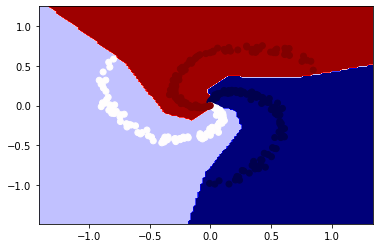

In [37]:
import dl_numpy as DL
import utilities
import matplotlib.pyplot as plt

batch_size        = 20
num_epochs        = 200
samples_per_class = 100
num_classes       = 3
hidden_units      = 100
data,target       = utilities.genSpiralData(samples_per_class,num_classes)
model             = utilities.Model()
model.add(DL.Linear(2,hidden_units))
model.add(ReLU())
model.add(DL.Linear(hidden_units,num_classes))
optim   = SGD(model.parameters,lr=1.0,weight_decay=0.001,momentum=.9)
loss_fn = SoftmaxWithLoss()
model.fit(data,target,batch_size,num_epochs,optim,loss_fn)
predicted_labels = np.argmax(model.predict(data),axis=1)
accuracy         = np.sum(predicted_labels==target)/len(target)
print("Model Accuracy = {}".format(accuracy))
plot2DDataWithDecisionBoundary(data,target,model)